In [40]:
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [41]:
data = None
with open("benchmark_results.yaml") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [46]:
implementations = [key for key in data["200.yaml"]]
grid_sizes = [int(key.split(".")[0]) for key in data]
grid_sizes.sort()

def to_key(size):
    return "{}.yaml".format(size)

implementations_dict = {}

for implementation in implementations:
    median = []
    mean = []
    max = []
    min = []
    
    for size in grid_sizes:
        if(implementation in data[to_key(size)]):
            times = data[to_key(size)][implementation]["time"]
            
            median.append(times["median"])
            mean.append(times["mean"])
            min.append(times["min"])
            max.append(times["max"])
            
    implementations_dict[implementation] = {
        "median" : np.array(median),
        "mean" : np.array(mean),
        "max" : np.array(max),
        "min" : np.array(min)
    }
    
baseline = "cpp_naive"

for implementation in implementations_dict:
    min_length = np.min([implementations_dict[implementation]["mean"].size, implementations_dict[baseline]["mean"].size])
    implementations_dict[implementation]["mean_speedup"] = implementations_dict[baseline]["mean"][:min_length] / implementations_dict[implementation]["mean"][:min_length]

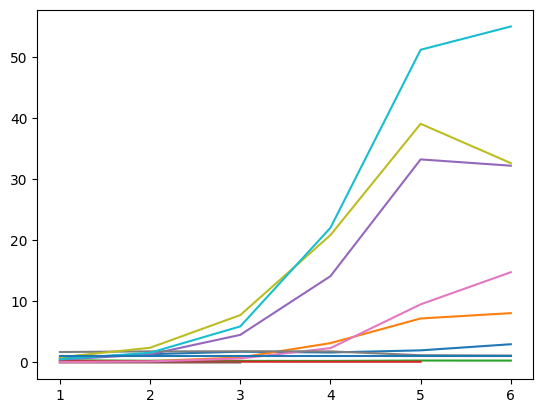

In [48]:
def plot_implementations(implementations, data_dict, category="mean_speedup"):
    
    for implementation in implementations:
        data = data_dict[implementation][category]
        space = np.linspace(1, data.size, data.size)
        plt.plot(space, data)
        
plot_implementations(implementations, implementations_dict)

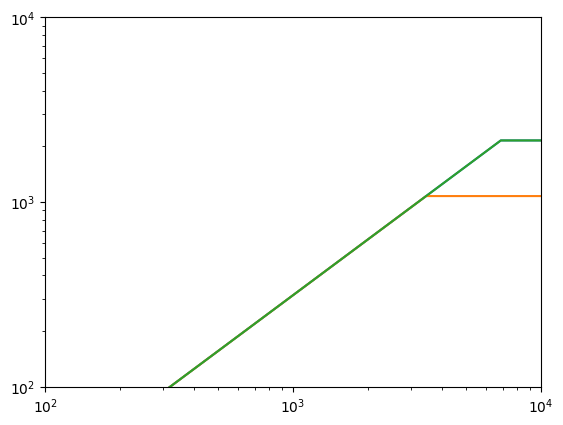

In [31]:
sp_compute = 2150
dp_compute = sp_compute / 2

plt.loglog(x, y)
plt.xlim([100, 10000])
plt.ylim([100, 10000])

#sp ideal cache
x = [0, 3440, 10000]
y = [0, sp_compute, sp_compute]

#dp ideal cache
x = [0, 3440, 10000]
y = [0, dp_compute, dp_compute]
plt.loglog(x, y)

#sp cache agnostic no full row fits in cache
x = [0, 6880, 10000]
y = [0, sp_compute, sp_compute]
plt.loglog(x, y)